# How to Draw t-SNE Figs Similar to Ours in Paper

A simple example in a subset of VTAB dataset

First, import all the libraries and load the dataset

In [ ]:
from make_dataset.get_data import vtab
import numpy as np
import pandas as pd
from make_dataset.incre_dataset import BasicDataset,IncrementDataset,select_data_with_labels
from torch.utils.data import DataLoader
import torch
import json
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from dl_models.DPTA import Learner
def load_json(settings_path):
    with open(settings_path) as data_file:
        param = json.load(data_file)
    return param

args = load_json('exp_params/vtab_10_10_vit-im21_adapter.json')

vtab_dataset = vtab() #load the vtab data
vtab_dataset.download_data(train_dir='make_dataset/dataset/vtab/train',test_dir='make_dataset/dataset/vtab/test')

e:\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Here we use the first five classes in task 1 of the VTAB dataset as on-task samples, the trained adapter can be found in./adapters/vtab.

In [2]:
incdata = IncrementDataset(init_cls=0,increment=10)
dataset1= incdata.get_dataset(np.arange(0, 5), source="test", mode="test")
loaders1 = DataLoader(dataset1,batch_size=9999,shuffle=False) #big batch_size, we select all samples in loader in a stupid way

#off-task samples with class 20-30
dataset2= incdata.get_dataset(np.arange(20, 27), source="test", mode="test")
loaders2 = DataLoader(dataset2,batch_size=9999,shuffle=False)
for i,x1,y1 in loaders1:
    x1 = x1.cuda()

for i,x2,y2 in loaders2:
    x2 = x2.cuda()

Load the DPTA model, set the load_model = True to load the adapters.

We have proposed five trained adapters in VTAB dataset in our code.

In [ ]:
model = Learner(args,load_model=True,load_dir='adapters/vtab')
network = model._network.to('cuda')
ptm = network.ptm

Test the model's accuracy:

In [10]:
for tasks in range(incdata.nb_tasks):
    model.incremental_train(incdata) # if load the model, we do not train the adapter again,and here we just build two prototypes.
dataset= incdata.get_dataset(np.arange(0, 50), source="test", mode="test")
loaders = DataLoader(dataset,batch_size=32,shuffle=True)
acc = model.eval_task_custom(loaders)
print(f'A_F acc on VTAB:{acc*100}%')

start evals
A_F acc on VTAB:93.73425970077514%


Feature Extraction by the PTM

In [4]:
#forward proto is extract the representation of samples. withoutft means with out adapter.
emb1 = ptm.forward_proto_withoutft(x1) #without adaption
emb1 = emb1.cpu().detach()

emb2 = ptm.forward_proto(x1,adapt_index=0) #correct adapter
emb2 = emb2.cpu().detach()

#outliers:
emb3 = ptm.forward_proto(x2,adapt_index=0)# off-task samples
emb3 = emb3.cpu().detach()
emb4 = ptm.forward_proto(x1,adapt_index=3)# on-task sample but selected the wrong adapter
emb4 = emb4.cpu().detach()

In [6]:
dict1 ={'emb1':emb1,
        'emb2':emb2,
        'emb3':emb3,
        'emb4':emb4,

        'y1':y1,
        'y2':y2,
}
torch.save(dict1,'tsne_dict.pt')

The dataset is too large to upload, so here we saved the data subset into .pt file for loading.

In [34]:
dict1 = torch.load('tsne_dict.pt')
emb1 = dict1['emb1']
emb2 = dict1['emb2']
emb3 = dict1['emb3']
emb4 = dict1['emb4']
y1 = dict1['y1']
y2 = dict1['y2']

Draw the sample representations with original PTM

Note that the figure of each startup code run may be different. There may be some differences in the positions of the clusters here and the Figure 3 in the paper, but the spatial distribution of samples is similar.

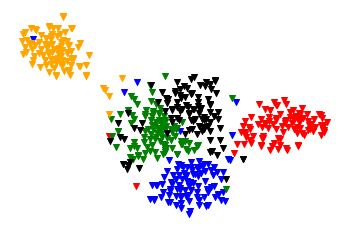

In [66]:
tsne = TSNE()
np.random.seed(40)
emb1tsne = tsne.fit_transform(emb1)
datas1 = pd.DataFrame(emb1tsne)
datas1['labels']=y1

color_list = ['red','blue','green','black','orange']
#marker_list = ['8','v','^','v','^']
marker = 'v'
for i in range(5):
    class_data = datas1[datas1['labels']==i]
    plt.scatter(class_data.iloc[:,0],class_data.iloc[:,1],edgecolor='face',label = f'c{i}',c=color_list[i],marker=marker)
plt.axis('off')
plt.show()

Draw the sample representations of on-task samples in the subspace

We can see that with adapted PTM, the sample representations are clustered towards the class center and more separable.

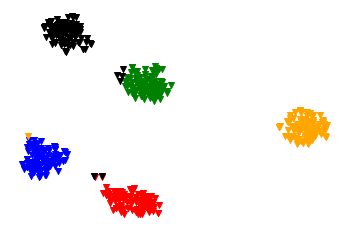

In [68]:
tsne = TSNE()
np.random.seed(20)
emb2tsne = tsne.fit_transform(emb2)
datas2 = pd.DataFrame(emb2tsne)
datas2['labels']=y1

color_list = ['red','blue','green','black','orange']
for i in range(5):
    class_data = datas2[datas2['labels']==i]
    plt.scatter(class_data.iloc[:,0],class_data.iloc[:,1],edgecolor='face',label = f'c{i}',c=color_list[i],marker=marker)
plt.axis('off')
plt.show()

Draw the sample representations of on-task samples and outliers in the subspace,the outliers will be far away from on-task samples.

Please notice, if you want to draw outliers with on-task samples, please use one t-SNE model to embedding them in one subspace.

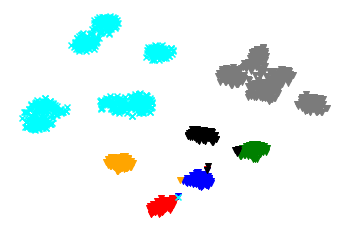

In [ ]:
emb23 = torch.cat([emb2,emb3,emb4])
label23 = torch.cat([y1,y2,(y1-10)])
tsne = TSNE()
np.random.seed(30) #set the random seed to draw different fig
emb2tsne = tsne.fit_transform(emb23)
datas2 = pd.DataFrame(emb2tsne)
datas2['labels']=label23

marker = 'v'
color_list = ['red','blue','green','black','orange']
#on task samples with the correct adapter
for i in range(5):
    class_data = datas2[datas2['labels']==i]
    plt.scatter(class_data.iloc[:,0],class_data.iloc[:,1],label = f'c{i}',c=color_list[i],marker=marker)
plt.axis('off')

## OUTLIERS:
for i in range(5):
    class_data = datas2[datas2['labels']==i-10]
    plt.scatter(class_data.iloc[:,0],class_data.iloc[:,1],label = f'c{i}',c='#7B7B7B',marker=marker)
plt.axis('off')
for i in range(20,27):
    class_data = datas2[datas2['labels']==i]
    plt.scatter(class_data.iloc[:,0],class_data.iloc[:,1],label ='others',c='#00FEFE',marker='x')
plt.axis('off')
plt.show()